In [2]:
# Importing Dependencies 
import numpy as np
import pandas as pd
import librosa 

import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import wavfile

In [3]:
# data paths
DEV_DATA_PATH = "data/development.csv"   
EVAL_DATA_PATH = "data/evaluation.csv"  

# load datasets
df_dev = pd.read_csv(DEV_DATA_PATH, index_col='Id') 
df_eval = pd.read_csv(EVAL_DATA_PATH, index_col='Id')

# simple transformations inferred from first exploration of the data
def preprocess_and_transform_columns(df):
    df = df.rename(columns={"age": "target"})  # Rename 'age' to 'target'
    df = df.drop(columns=["sampling_rate", "path"])  # Remove unnecessary columns
    df["tempo"] = df["tempo"].apply(lambda x: float(x[1:-1]))  # Transform 'tempo' values from 'str' to 'float'
    df["gender"] = df["gender"].replace("famale", "female") # Single typo in evaluation dataset
    return df

df_dev = preprocess_and_transform_columns(df_dev)
df_eval = preprocess_and_transform_columns(df_eval)

df_dev_copy = df_dev.copy()
df_eval_copy = df_eval.copy()

int16


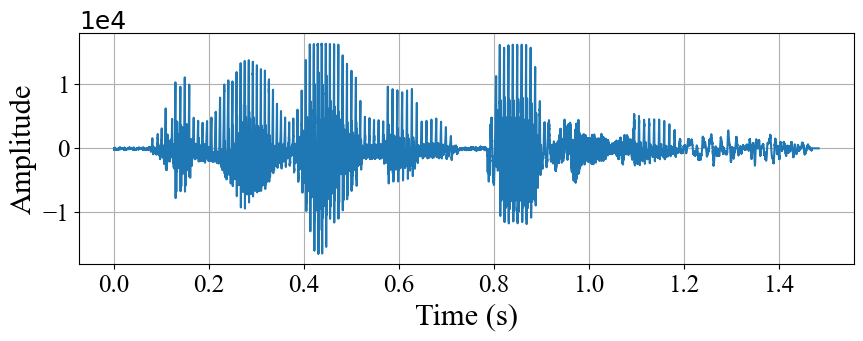

In [23]:
path_audio = 'data/audios_development/10.wav'
sr, audio_wav = wavfile.read(path_audio)
print(audio_wav.dtype)
audio_wav_mono = audio_wav.sum(axis=1)/2

mpl.rcParams["font.size"] = 18

fig, ax = plt.subplots(1, figsize=(10,3))

v = audio_wav_mono

time = np.arange(v.size)/sr
ax.plot(time, v)
ax.grid(visible=True)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_xlabel('Time (s)', fontsize=22, fontname='Times New Roman')
ax.set_ylabel('Amplitude', fontsize=22, fontname='Times New Roman')
plt.xticks(fontsize=18, color='black', fontname='Times New Roman')
plt.yticks(fontsize=18, color='black', fontname='Times New Roman')
plt.show()
fig.savefig("figs/audio_track.pdf", bbox_inches="tight")

In [5]:
from utils import audio_preprocessing as ap

input_file = "data/audios_development/9.wav"
def plot_audio(y, sr=22050, c='b', s=False, ax=None, title='Audio Signal'):
    if ax == None:
        fig, ax = plt.subplots(1, figsize=(10,3))
    if s:
        ax.plot(np.arange(y.size)/sr, y, c=c)
    else:
        ax.plot(y, c=c)
    ax.title.set_text(title)
    return ax

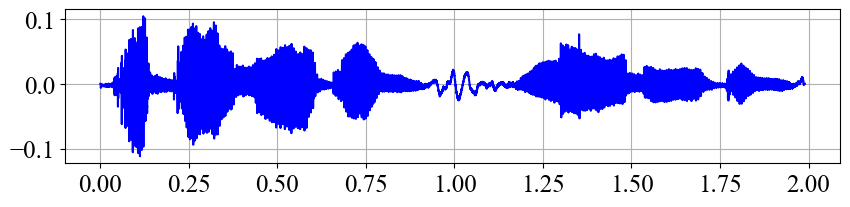

In [24]:
y, sr = librosa.load(input_file)
fig, ax = plt.subplots(1, figsize=(10,2))
ax.grid(visible=True)
# plot_audio(y, c='orange', s=True, ax=ax, title = 'Original Audio')
plot_audio(y, c='blue', s=True, ax=ax, title = '')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.xticks(fontsize=18, color='black', fontname='Times New Roman')
plt.yticks(fontsize=18, color='black', fontname='Times New Roman')
plt.show()
fig.savefig("figs/audio_track_original.pdf", bbox_inches="tight")

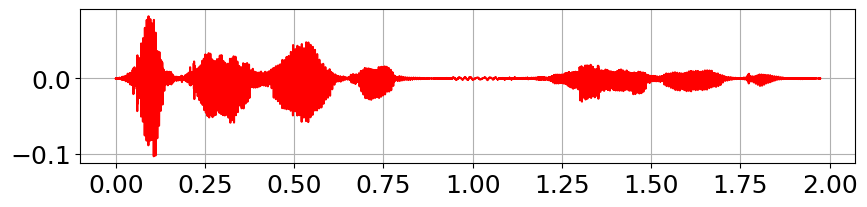

In [ ]:
y_noise = ap.reduce_noise(y=y, sr=sr)
y_filter = ap.bandpass_filter(y=y_noise, sr=sr)

fig, ax = plt.subplots(1, figsize=(10,2))
ax.grid(visible=True)
# plot_audio(y_filter, c='red', s=True, ax=ax, title = 'Filtered Audio')
plot_audio(y_filter, c='red', s=True, ax=ax, title = '')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.xticks(fontsize=18, color='black', fontname='Times New Roman')
plt.yticks(fontsize=18, color='black', fontname='Times New Roman')
plt.show()
fig.savefig("figs/audio_track_filtered.pdf", bbox_inches="tight")

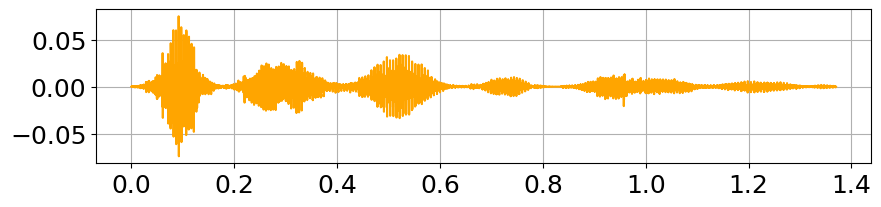

In [ ]:
y_processed = ap.process_audio(y=y_filter, sr=sr, top_db=20)

fig, ax = plt.subplots(1, figsize=(10,2))
# plot_audio(y_processed, c='orange', s=True, ax=ax, title = 'Processed Audio')
plot_audio(y_processed, c='orange', s=True, ax=ax, title = '')
ax.grid(visible=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.xticks(fontsize=18, color='black', fontname='Times New Roman')
plt.yticks(fontsize=18, color='black', fontname='Times New Roman')
plt.show()
fig.savefig("figs/audio_track_processed.pdf", bbox_inches="tight")

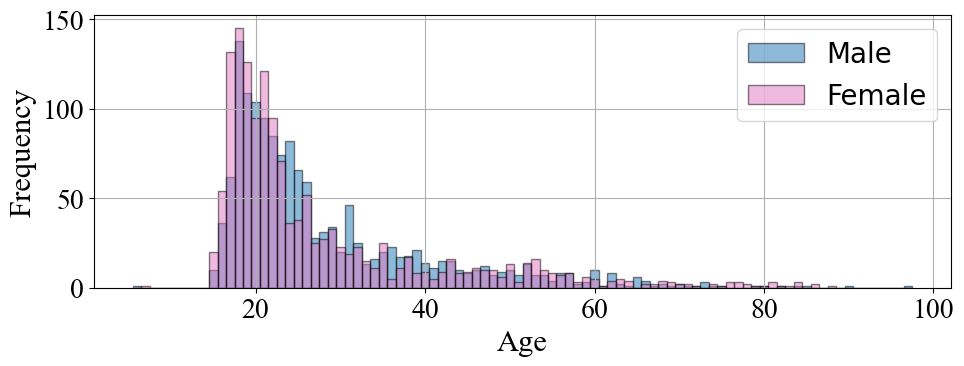

In [30]:
dev_gender = df_dev_copy["gender"].copy()
eval_gender = df_eval_copy["gender"].copy()

dev_labels, dev_sizes = dev_gender.value_counts().index, dev_gender.value_counts().values
eval_labels, eval_sizes = eval_gender.value_counts().index, eval_gender.value_counts().values

TARGET = df_dev_copy["target"].copy()

age_male = TARGET[df_dev_copy["gender"] == "male"]
age_female = TARGET[df_dev_copy["gender"] == "female"]

# bins for both distributions
bins = np.arange(min(age_male.min(), age_female.min()) - 0.5, 
                 max(age_male.max(), age_female.max()) + 1.5, 1)

plt.figure(figsize=(10, 4))
plt.hist(age_male, bins=bins, edgecolor="black", align="mid", color="tab:blue", alpha=.5, label="Male")
plt.hist(age_female, bins=bins, edgecolor="black", align="mid", color="tab:pink", alpha=.5, label="Female")
# plt.title("Age Distribution by Gender (Development Dataset)")
plt.xlabel("Age", fontsize=22, fontname='Times New Roman')
plt.ylabel("Frequency", fontsize=22, fontname='Times New Roman')
plt.legend(fontsize=20)
plt.xticks(fontsize=20, color='black', fontname='Times New Roman')
plt.yticks(fontsize=20, color='black', fontname='Times New Roman')
plt.tight_layout()
plt.grid()
plt.savefig("figs/age_distribution.pdf", bbox_inches="tight")
plt.show()

Total unique outliers: 204
Common outliers: 26


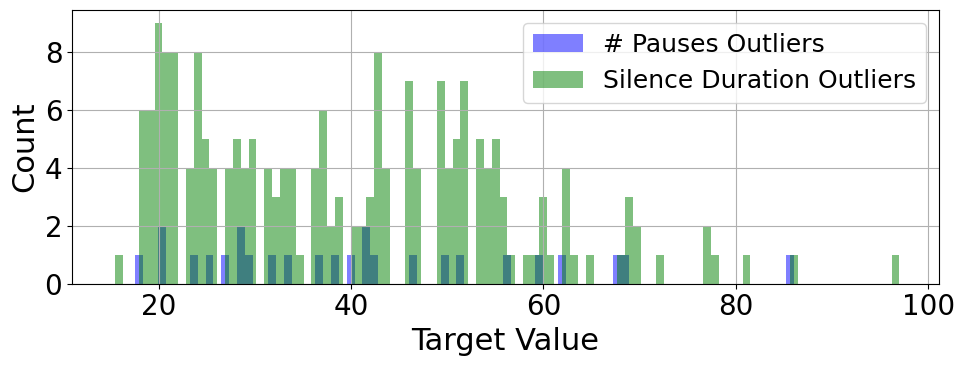

In [17]:
num_pauses_outliers = df_dev_copy["num_pauses"] > 57 # Over 99th percentile
silence_duration_outliers = df_dev_copy["num_pauses"] > 37.87 # Over 99th percentile

total_unique_outliers = (num_pauses_outliers | silence_duration_outliers).sum()
common_outliers = (num_pauses_outliers & silence_duration_outliers).sum()

print(f"Total unique outliers: {total_unique_outliers}")
print(f"Common outliers: {common_outliers}")

# Extract target values for each type of outlier
num_pauses_target = df_dev_copy["target"][num_pauses_outliers]
silence_duration_target = df_dev_copy["target"][silence_duration_outliers]
# common_targets = df_dev_copy["target"][num_pauses_outliers & silence_duration_outliers]

# Combine all three to find overall min/max
all_data = np.concatenate([num_pauses_target, silence_duration_target])
common_min, common_max = all_data.min(), all_data.max()

plt.figure(figsize=(10, 4))
plt.hist(num_pauses_target, range=(common_min, common_max), bins=100, alpha=0.5, color='blue',  label='# Pauses Outliers', align="left")
plt.hist(silence_duration_target,   range=(common_min, common_max), bins=100, alpha=0.5, color='green', label='Silence Duration Outliers', align="mid")
# plt.hist(common_targets,   range=(common_min, common_max), bins=100, alpha=0.5, color='red',   label='Common Outliers', align="right")

plt.xlabel("Target Value", fontsize=22)
plt.ylabel("Count", fontsize=22)

plt.legend(fontsize=18)
plt.xticks(fontsize=20, color='black')
plt.yticks(fontsize=20, color='black')
plt.tight_layout()
plt.grid()
plt.savefig("figs/outliers_silences_target.pdf", bbox_inches="tight")
plt.show()